In [11]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/CVPR/animal_dataset.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully.


In [12]:
import cv2
import numpy as np
from glob import glob

# Define parameters
IMG_SIZE = 32
dataset_root_path = '/content/dataset/animal_dataset'

def load_and_preprocess_data(base_path):
    data = []
    labels = []
    class_names = os.listdir(base_path)
    class_map = {name: idx for idx, name in enumerate(class_names)}

    print(f"Classes found: {class_names}")

    for class_name in class_names:
        folder_path = os.path.join(base_path, class_name)
        image_paths = glob(os.path.join(folder_path, "*.jpg")) + glob(os.path.join(folder_path, "*.png"))

        for img_path in image_paths:
            # Read image
            img = cv2.imread(img_path)
            if img is None: continue

            # 1. Convert to Grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # 2. Resize to 32x32
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Flatten the image (32*32 = 1024 features) for KNN
            img_flattened = img.flatten()

            data.append(img_flattened)
            labels.append(class_map[class_name])

    return np.array(data), np.array(labels), class_names

X, y, class_names = load_and_preprocess_data(dataset_root_path)
print(f"Data Shape: {X.shape}, Labels Shape: {y.shape}")

Classes found: ['panda', 'dog', 'cat']
Data Shape: (300, 1024), Labels Shape: (300,)


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Range of K values to test
k_values = range(1, 21)

# Store average accuracies
acc_l1 = [] # Manhattan
acc_l2 = [] # Euclidean

print("Starting 5-Fold Cross-Validation...")

for k in k_values:
    # --- Manhattan Distance (p=1) ---
    knn_l1 = KNeighborsClassifier(n_neighbors=k, p=1, metric='manhattan')
    scores_l1 = cross_val_score(knn_l1, X, y, cv=5, scoring='accuracy')
    acc_l1.append(scores_l1.mean())

    # --- Euclidean Distance (p=2) ---
    knn_l2 = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')
    scores_l2 = cross_val_score(knn_l2, X, y, cv=5, scoring='accuracy')
    acc_l2.append(scores_l2.mean())

print("Evaluation complete.")

Starting 5-Fold Cross-Validation...
Evaluation complete.


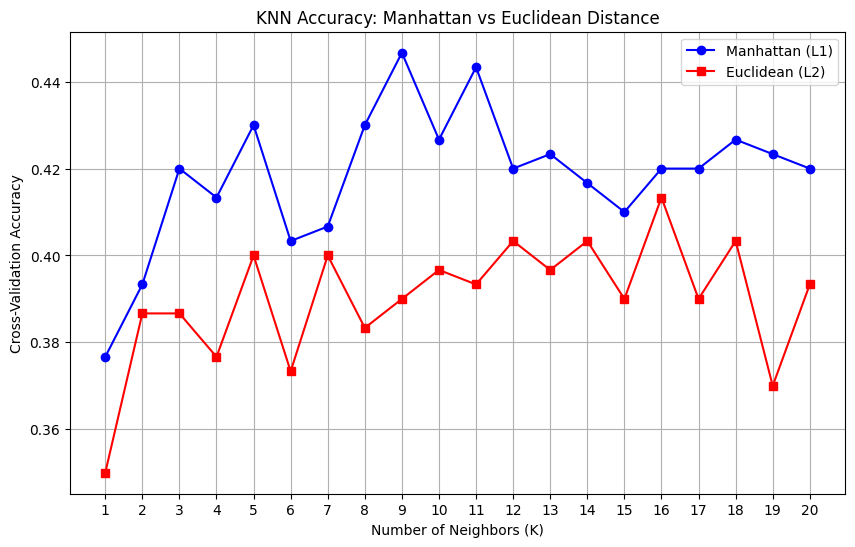

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, acc_l1, marker='o', label='Manhattan (L1)', color='blue')
plt.plot(k_values, acc_l2, marker='s', label='Euclidean (L2)', color='red')

plt.title('KNN Accuracy: Manhattan vs Euclidean Distance')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

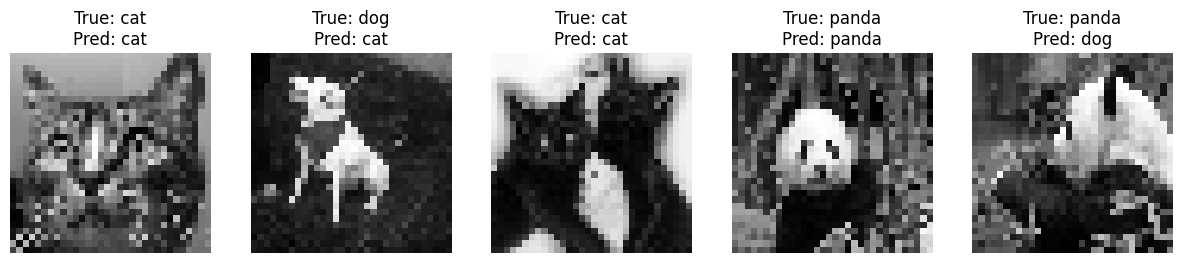

In [15]:
import random

# Split data to train a final model for demonstration
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model (using K=5 and Euclidean as an example)
final_model = KNeighborsClassifier(n_neighbors=5, p=2)
final_model.fit(X_train, y_train)

# Pick 5 random test images
indices = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image_data = X_test[idx].reshape(32, 32)
    true_label = class_names[y_test[idx]]
    prediction = final_model.predict([X_test[idx]])[0]
    pred_label = class_names[prediction]

    plt.subplot(1, 5, i+1)
    plt.imshow(image_data, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.show()